In [1]:
# Run this cell first (umap-learn may not be preinstalled)
!pip install -q umap-learn scikit-learn

## Import, seeds, device info

##Import necessary module

In [2]:
import os, random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sklearn.metrics import silhouette_score

# Reproducibility
SEED = 1337
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

##Load MNIST and build tf.data pipelines (resize → RGB → preprocess_input)

In [3]:
# Load raw MNIST (uint8, shape: (N,28,28))
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Add channel dim (H,W,1)
x_train = x_train[..., np.newaxis]
x_test  = x_test[..., np.newaxis]

IMG_SIZE = 224   # ResNet50 expects >= 197; 224 is standard
BATCH = 64       # reduce if you run OOM (try 32 or 16)

def preprocess_image(image):
    # image: uint8 [H,W,1] or [H,W,1] tensor
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = tf.image.grayscale_to_rgb(image)           # -> (H,W,3)
    image = tf.cast(image, tf.float32)                 # keep pixel range 0-255
    image = preprocess_input(image)                    # ResNet50 preprocessing
    return image

def make_dataset(x, y, batch=BATCH, training=False):
    ds = tf.data.Dataset.from_tensor_slices((x, y))
    if training:
        ds = ds.shuffle(10000, seed=SEED)
    ds = ds.map(lambda im, lab: (preprocess_image(im), lab), num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_dataset(x_train, y_train, batch=BATCH, training=True)
test_ds  = make_dataset(x_test,  y_test,  batch=BATCH, training=False)

print("Train size:", x_train.shape[0], "Test size:", x_test.shape[0])


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Train size: 60000 Test size: 10000


##build two model **instances**

In [4]:
# Base for BEFORE feature extraction (frozen)
base_before = DenseNet121(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_before.trainable = False
feat_before = layers.GlobalAveragePooling2D(name='gap_before')(base_before.output)
feature_extractor_before = Model(inputs=base_before.input, outputs=feat_before, name='feat_ext_before')
feature_extractor_before.summary()

# Base for training (we'll set trainable below in two-step fine-tuning)
base_train = DenseNet121(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_train.output
x = layers.GlobalAveragePooling2D(name='gap')(x)           # give it a name to easily fetch later
predictions = layers.Dense(10, activation='softmax', name='pred')(x)
train_model = Model(inputs=base_train.input, outputs=predictions, name='densenet121_mnist')
train_model.summary()


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "feat_ext_before"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,037,504 (26.85 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 7,037,504 (26.85 MB)

Model: "densenet121_mnist"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d_2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_3… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,047,754 (26.89 MB)

 Trainable params: 6,964,106 (26.57 MB)

 Non-trainable params: 83,648 (326.75 KB)

##Extract features BEFORE fine-tuning (penultimate vector)

In [5]:
# Predict features on test set (this uses frozen ImageNet weights)
features_before = feature_extractor_before.predict(test_ds, verbose=1)  # shape (10000, D)
labels = y_test  # numpy array of length 10000

print("features_before shape:", features_before.shape)


157/157 ━━━━━━━━━━━━━━━━━━━━ 67s 235ms/step
features_before shape: (10000, 1024)


##Fine-tune the model on MNIST (two-stage: train head, then unfreeze & fine-tune whole net)

In [6]:
# 1) Train head only (freeze base)
base_train.trainable = False
train_model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])
history_head = train_model.fit(train_ds, validation_data=test_ds, epochs=10)

# Evaluate after head-only training (before transfer learning)
loss_before, acc_before = train_model.evaluate(test_ds, verbose=0)
print(f"Final test accuracy BEFORE transfer learning: {acc_before:.4f}")

# 2) Unfreeze base and fine-tune (lower LR)
base_train.trainable = True

# Optional: freeze batch-norm layers if desired; in practice you may keep them trainable.
# Recompile with a small learning rate
train_model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])
history_ft = train_model.fit(train_ds, validation_data=test_ds, epochs=10)

# Evaluate after fine-tuning (after transfer learning)
loss_after, acc_after = train_model.evaluate(test_ds, verbose=0)
print(f"Final test accuracy AFTER transfer learning: {acc_after:.4f}")


Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 207s 197ms/step - accuracy: 0.7964 - loss: 0.7434 - val_accuracy: 0.9469 - val_loss: 0.1919
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 145s 155ms/step - accuracy: 0.9504 - loss: 0.1800 - val_accuracy: 0.9590 - val_loss: 0.1406
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 203s 156ms/step - accuracy: 0.9614 - loss: 0.1356 - val_accuracy: 0.9641 - val_loss: 0.1215
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 201s 154ms/step - accuracy: 0.9654 - loss: 0.1167 - val_accuracy: 0.9669 - val_loss: 0.1091
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 202s 154ms/step - accuracy: 0.9703 - loss: 0.1032 - val_accuracy: 0.9691 - val_loss: 0.1079
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 203s 155ms/step - accuracy: 0.9719 - loss: 0.0935 - val_accuracy: 0.9697 - val_loss: 0.0984
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 201s 154ms/step - accuracy: 0.9734 - loss: 0.0854 - val_accuracy: 0.9723 - val_loss: 0.0911
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 203s 155ms/step - accuracy: 0.9751 -

KeyboardInterrupt: 

In [7]:
# Evaluate after fine-tuning (after transfer learning)
loss_after, acc_after = train_model.evaluate(test_ds, verbose=0)
print(f"Final test accuracy AFTER transfer learning: {acc_after:.4f}")

Final test accuracy AFTER transfer learning: 0.9908


##Build AFTER feature extractor and extract features

In [8]:
# After training, create a model that outputs the gap layer ('gap') — that is the penultimate vector
feature_extractor_after = Model(inputs=train_model.input, outputs=train_model.get_layer('gap').output, name='feat_ext_after')

features_after = feature_extractor_after.predict(test_ds, verbose=1)
print("features_after shape:", features_after.shape)


157/157 ━━━━━━━━━━━━━━━━━━━━ 45s 212ms/step
features_after shape: (10000, 1024)


##Dimensionality reduction helpers PCA & plotting utilities

In [9]:
def subsample(features, labels, n=3000, seed=SEED):
    if features.shape[0] <= n:
        return features, labels
    rng = np.random.RandomState(seed)
    idx = rng.choice(np.arange(features.shape[0]), size=n, replace=False)
    return features[idx], labels[idx]

def embed_and_plot(X, y, title, method='pca', subsample_n=None, savepath=None):
    if subsample_n is not None:
        Xr, yr = subsample(X, y, n=subsample_n)
    else:
        Xr, yr = X, y

    if method == 'pca':
        R = PCA(n_components=2, random_state=SEED).fit_transform(Xr)
    elif method == 'tsne':
        R = TSNE(n_components=2, random_state=SEED, init='pca', perplexity=30).fit_transform(Xr)
    elif method == 'umap':
        R = umap.UMAP(n_components=2, random_state=SEED).fit_transform(Xr)
    else:
        raise ValueError("Unknown method")

    plt.figure(figsize=(7,6))
    scatter = plt.scatter(R[:,0], R[:,1], c=yr, cmap='tab10', s=6, alpha=0.8)
    plt.title(f"{title} — {method.upper()}")
    plt.xlabel('Dim 1'); plt.ylabel('Dim 2')
    plt.colorbar(ticks=range(10), label='digit')
    if savepath:
        plt.savefig(savepath, dpi=200, bbox_inches='tight')
    plt.show()

def compute_silhouette(X, y, method='pca', subsample_n=3000):
    Xr, yr = subsample(X, y, n=subsample_n)
    if method == 'pca':
        R = PCA(n_components=2, random_state=SEED).fit_transform(Xr)
    elif method == 'tsne':
        R = TSNE(n_components=2, random_state=SEED, init='pca', perplexity=30).fit_transform(Xr)
    elif method == 'umap':
        R = umap.UMAP(n_components=2, random_state=SEED).fit_transform(Xr)
    else:
        raise ValueError("Unknown method")
    s = silhouette_score(R, yr, metric='euclidean')
    return s


##Plot BEFORE vs AFTER for PCA


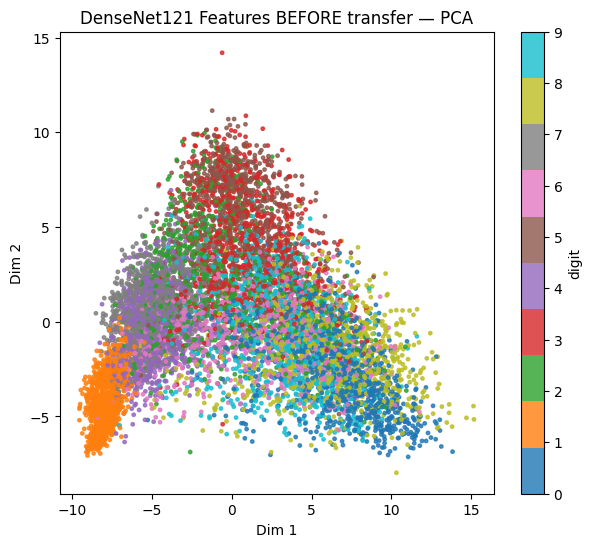

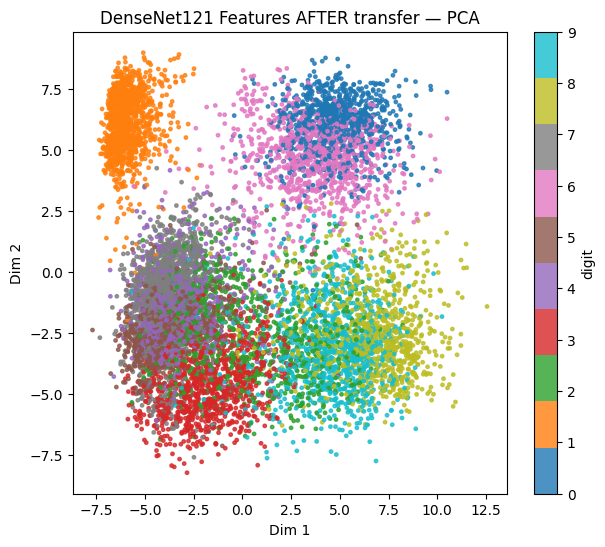

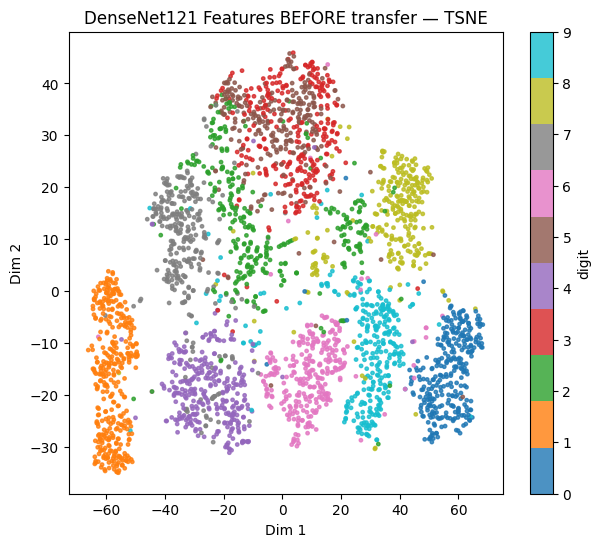

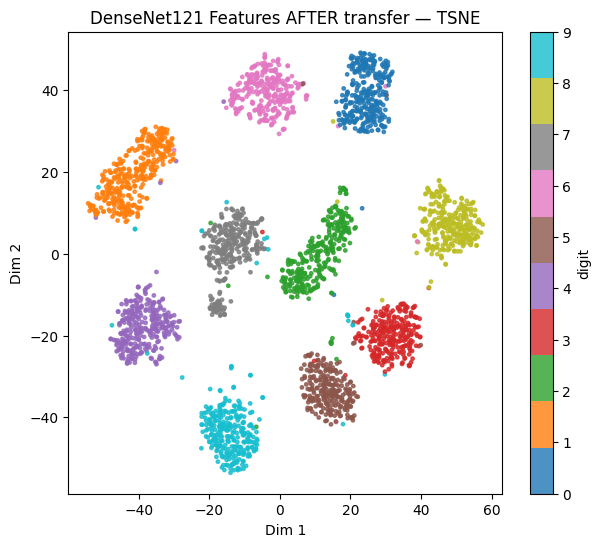

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


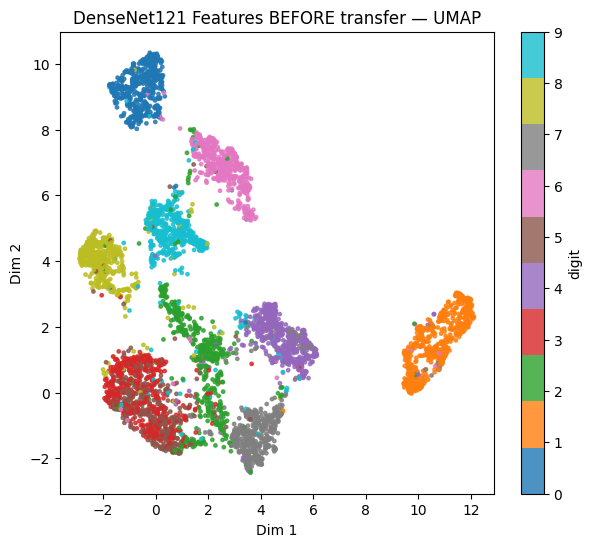

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


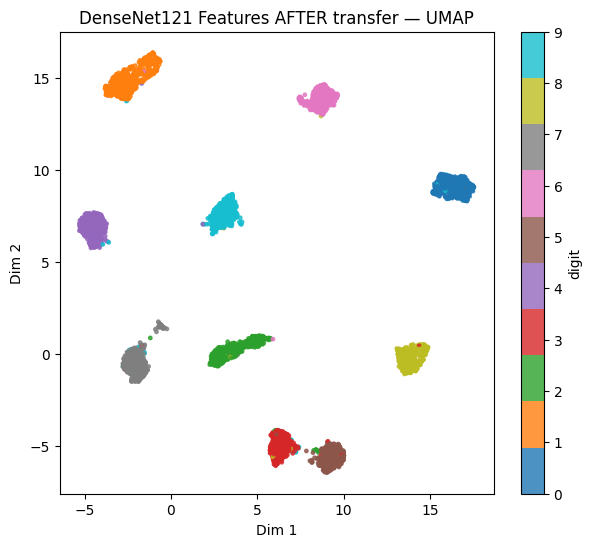

In [10]:
# Convert to numpy arrays (they already are numpy from predict)
Xb, yb = features_before, labels
Xa, ya = features_after, labels

# PCA (use all samples)
embed_and_plot(Xb, yb, "DenseNet121 Features BEFORE transfer", method='pca', subsample_n=None, savepath='before_pca.png')
embed_and_plot(Xa, ya, "DenseNet121 Features AFTER transfer",  method='pca', subsample_n=None, savepath='after_pca.png')

# t-SNE (subsample to speed up)
embed_and_plot(Xb, yb, "DenseNet121 Features BEFORE transfer", method='tsne', subsample_n=3000, savepath='before_tsne.png')
embed_and_plot(Xa, ya, "DenseNet121 Features AFTER transfer",  method='tsne', subsample_n=3000, savepath='after_tsne.png')

# UMAP (subsample optional)
embed_and_plot(Xb, yb, "DenseNet121 Features BEFORE transfer", method='umap', subsample_n=5000, savepath='before_umap.png')
embed_and_plot(Xa, ya, "DenseNet121 Features AFTER transfer",  method='umap', subsample_n=5000, savepath='after_umap.png')


##Compute silhouette scores (2D embeddings) as a quantitative proxy

In [11]:
for method in ['pca', 'tsne', 'umap']:
    s_before = compute_silhouette(Xb, yb, method=method, subsample_n=3000)
    s_after  = compute_silhouette(Xa, ya, method=method, subsample_n=3000)
    print(f"{method.upper():5s} | BEFORE: {s_before:.4f}  | AFTER: {s_after:.4f}")



PCA   | BEFORE: -0.0219  | AFTER: 0.1102
TSNE  | BEFORE: 0.2807  | AFTER: 0.6347


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP  | BEFORE: 0.3354  | AFTER: 0.7747
